### Exercise 2: Classification of Airline Tweets with RNN’s

##### Import the libraries necessary for this project.

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, Attention, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings

nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nosic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nosic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Data Preprocessing: Loading the dataset and preprocessing steps as in Exercise 1.

In [2]:
def remove_unwanted(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    emojis = re.compile(
        "[\U0001F600-\U0001F64F" # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]", flags=re.UNICODE
    )
    text = emojis.sub(r'', text)
    return text

def preprocessing(sentence):
    sentence = remove_unwanted(sentence)
    sentence = sentence.lower()
    tokens = word_tokenize(sentence, language='english', preserve_line=True)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = " ".join(filtered_tokens)
    return filtered_tokens

tweets_df = pd.read_csv("datasets/Tweets.csv", encoding="utf-8")
tokens = [preprocessing(sentence) for sentence in tweets_df['text']]
tweets_df['text'] = [" ".join(token) for token in tokens]
tweets_df['text']

0                                                   said .
1         plus 've added commercial experience ... tacky .
2         n't today ... must mean need take another trip !
3        's really aggressive blast obnoxious `` entert...
4                                  's really big bad thing
                               ...                        
14635                 thank got different flight chicago .
14636    leaving 20 minute late flight. warning communi...
14637                        please bring american airline
14638    money , change flight , n't answer phone ! sug...
14639    8 ppl need 2 know many seat next flight. plz p...
Name: text, Length: 14640, dtype: object

##### Encode sentiment labels and set X as texts and numeric labels as y.

In [3]:
label_encoder = LabelEncoder()
tweets_df['label'] = label_encoder.fit_transform(tweets_df['airline_sentiment'])
X = tweets_df['text']
y = tweets_df['label']

##### Tokenizing and padding the text data. Split into training and testing sets.

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, padding='post')
vocab_size = len(tokenizer.word_index) + 1

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

##### Model Training: Build RNN with Bi-LSTM, stacking multiple RNN layers and attention mechanism.

In [5]:
# Model Architecture: Stacked Bi-LSTM with Attention
inputs=Input(shape=(X_train.shape[1],))

# Embedding layer
embedding = Embedding(vocab_size, 64, input_length=(X_train.shape[1], X_train.shape[-1]))(inputs)

# Adding Bidirectional LSTM layers
lstm1 = Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1)))(embedding)
lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)

# Adding attention layer
attention = Attention()([lstm2, lstm2])

# Dense output layer
dense1 = Dense(64, activation='relu')(attention)
dropout = Dropout(0.2)(dense1)

# Output layer for classification
outputs = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5)

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.4583 - loss: 1.9338 - val_accuracy: 0.6290 - val_loss: 0.8254
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6123 - loss: 0.7487 - val_accuracy: 0.6417 - val_loss: 0.7072
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.6286 - loss: 0.6234 - val_accuracy: 0.6398 - val_loss: 0.7093
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6244 - loss: 0.5388 - val_accuracy: 0.6358 - val_loss: 0.6698
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6156 - loss: 0.4031 - val_accuracy: 0.6415 - val_loss: 0.7637
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6210 - loss: 0.2947 - val_accuracy: 0.6449 - val_loss: 0.7518
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6252 - loss: 0.2594 - val_accuracy: 0.6443 - val_loss: 0.9342
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6178 - loss: 0.2045 - val_acc

##### Plot the training and validation loss curves over epochs.

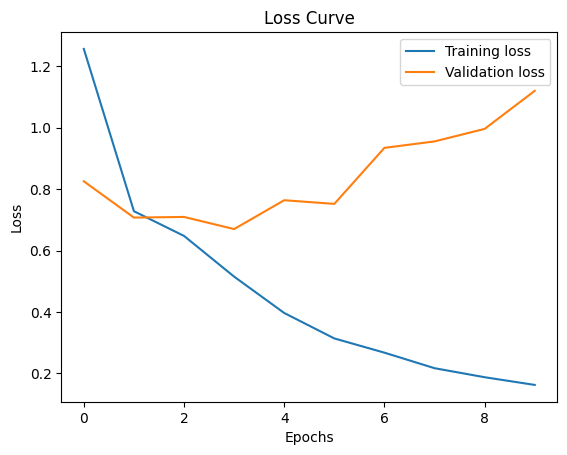

In [6]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Plot the confusion matrix with the help of the seaborn heatmap.

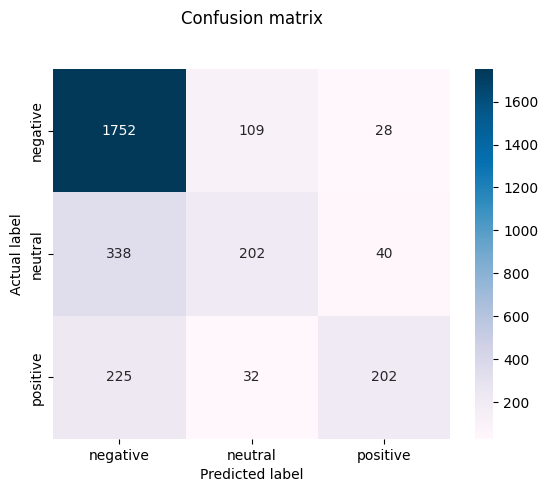

In [7]:
cm = confusion_matrix(y_test, np.argmax(y_pred,axis=1))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuBu" ,fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#### Explanation of the Model Architecture
##### Inputs: Defines input shape.
##### Embedding Layer: Converts the input words into dense vector representations.
##### Bidirectional LSTM: By adding two bidirectional LSTM layers, the model has access to both past and future context from the input sequence, which improves the learning of long-range dependencies.
##### Attention Mechanism: Computes attention over the outputs of the second LSTM layer. This mechanism helps the model focus on specific parts of the input sequence that are more important for classification.
##### Dense and Dropout Layers: Adds a dense layer followed by a dropout for regularization.
##### Output Layer: Final dense layer with sigmoid activation for classification.
##### Model Compilation: Compiles the model with Adam optimizer and sparse categorical crossentropy loss.